# A face Detection Pipeline 

This chapter has explored a number of the central concepts and algorithms of machine learning. But moving from these concepts to real-world application can be a challenge. Real-world datasets are noisy and heterogeneous, may have missing features, and data may be in a form that is difficult to map to a clean `[n_samples, n_features]` matrix. Before applying any of the methods discussed here, you must first extract these features from your data: there is no formula for how to do this that applies across all domains, and thus this is where you as a data scientist must exercise your own intuition and expertise.

One interesting and compelling application of machine learning is to iamges, and we have already seen a few examples of this where pixel-level features are used for classification. In the real world, data is rarely so uniform and simple pixels will not be suitable: this has lead to a large literatur on *feature extraction* methods for image data.

In this section, we will take a look at one such feature extraction technique, [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)(HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination. We will use these features to develp a simple face detection pipeline, using machine learning algorithms and concepts we've seen throughout this chapter.

We begin with the standard imports:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np 

## HOG Features

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrian within images. HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.

2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.

3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.

4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illuminatino across the iamge.

5. Construct a one-dimensional feature vector from the information in each cell.

As fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

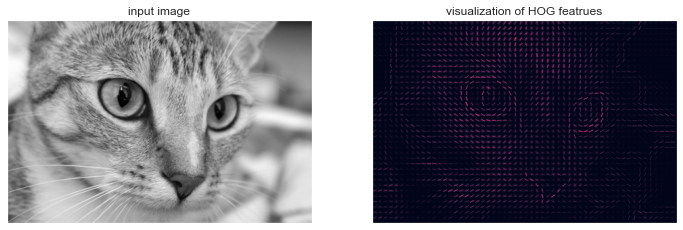

In [2]:
from skimage import data, color, feature 
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG featrues');

## HOG in Action: A simple face Detector 

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine. The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of iamge tumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate wheter that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples 

Let's start by finding some positive training samples that show a variety of faces. We have one easy set of data to work with -- the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

In [3]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

This gives us a sample of $13,000$ face images to use for training

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thimbnaisl which d*do not* have a face in them. One way to do this is to take any corpus of input iamges, and extract thumbnails from them at a variety of scales. Here we can use some of the iamges shipped with Scikit-Iamge, along with Scikit-Learn's `PatchExtractor`:

In [4]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
                'page', 'clock', 'immunohistochemistry',
                'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

<ipython-input-4-a29acc836b69>:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]


In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)

    patches = extractor.transform(img[np.newaxis])                               
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches 

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

negative_patches.shape

(30000, 62, 47)

We now have $30000$ suitable image patches which do not contain faces. Let's take a look at a few of them to get an idea of what they look like:

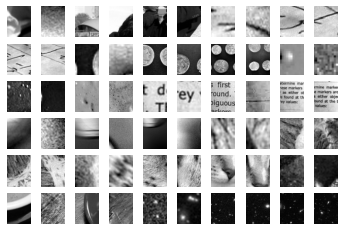

In [6]:
fig, ax = plt.subplots(6, 10)

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Our hpe is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

Now that we ahve these positive samples and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [8]:
from itertools import chain

X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches,
                                   negative_patches)])

y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [10]:
X_train.shape

(43233, 1215)

We are left with $43000$ training samples in $1215$ dimensions, and we now have our dat